In [17]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import df's
#note warning for mixed data types

data = pd.read_csv('data/final-complete-data-set.csv')
abnormal = pd.read_csv('data/final-anormal-data-set.csv')
normal = pd.read_csv('data/final-normal-data-set.csv')
 
data.info()

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (14,19,26,27,52,57) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95312 entries, 0 to 95311
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cpu_guest                      95311 non-null  float64
 1   cpu_guest_nice                 95311 non-null  float64
 2   cpu_idle                       95311 non-null  float64
 3   cpu_iowait                     95311 non-null  float64
 4   cpu_irq                        95310 non-null  float64
 5   cpu_nice                       95310 non-null  float64
 6   cpu_softirq                    95311 non-null  float64
 7   cpu_steal                      95310 non-null  float64
 8   cpu_system                     95311 non-null  float64
 9   cpu_total                      95310 non-null  float64
 10  cpu_user                       95311 non-null  float64
 11  diskio_sda1_disk_name          95312 non-null  object 
 12  diskio_sda1_key                95312 non-null 

In [3]:
# add target var to normal and abnormal df

#0 is not hijacked, 1 is not hijacked
normal['target'] = 0

abnormal['target'] = 1

abnormal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14461 entries, 0 to 14460
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cpu_guest                      14461 non-null  int64  
 1   cpu_guest_nice                 14461 non-null  int64  
 2   cpu_idle                       14461 non-null  float64
 3   cpu_steal                      14460 non-null  float64
 4   cpu_iowait                     14461 non-null  float64
 5   cpu_irq                        14460 non-null  float64
 6   cpu_nice                       14460 non-null  float64
 7   cpu_softirq                    14461 non-null  float64
 8   cpu_system                     14461 non-null  float64
 9   cpu_total                      14460 non-null  float64
 10  cpu_user                       14461 non-null  float64
 11  diskio_sda1_disk_name          14461 non-null  object 
 12  diskio_sda1_key                14461 non-null 

In [4]:
abnormal['target'].value_counts()

1    14461
Name: target, dtype: int64

In [5]:
#create merged df

df = normal.append(abnormal)


df.dropna(inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 95310 entries, 0 to 14460
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cpu_guest                      95310 non-null  float64
 1   cpu_guest_nice                 95310 non-null  float64
 2   cpu_idle                       95310 non-null  float64
 3   cpu_iowait                     95310 non-null  float64
 4   cpu_irq                        95310 non-null  float64
 5   cpu_nice                       95310 non-null  float64
 6   cpu_softirq                    95310 non-null  float64
 7   cpu_steal                      95310 non-null  float64
 8   cpu_system                     95310 non-null  float64
 9   cpu_total                      95310 non-null  float64
 10  cpu_user                       95310 non-null  float64
 11  diskio_sda1_disk_name          95310 non-null  object 
 12  diskio_sda1_key                95310 non-null 

In [45]:
# test for duplicates

print(df.duplicated().value_counts())

False    95310
dtype: int64


# Exploratory Data Analysis

As there are 81 different potential variables, understanding all the variables may be a struggle. As I am a data scientist, not a computer engineer, it becomes difficult to understand the shorthand version names listed such as "network_lo_cx" or "diskio_sdal_key". Fortunately, given the machine learning tools available, the algorithms will be able to parse through valuable numeric and discard. On the other hand, a brief scan through the variables shows that there is a high likelihood some of the numeric and object columns may be better scaled as categorial types.

One useful thing we will first do is to first parse through the object columns and see what the values of each show:

In [ ]:
#build list of columns that have non-int/float params

object_col_names = []

for name in list(df.columns):
    if df[name].dtypes == object:
        #examine printed values along with counts
        print("Value counts of unique vals in ", name, " col:", df[name].value_counts())
        print("Number of unique values in column ", name, " ", len(df[name].unique()))
        object_col_names.append(name)

From the output above we can see that there are some columns that need to be converted into numerical types, and there are others that are strings that may be worthwhile as categories. For the string col's:

1. vm4-web-server has 5 unique values:

vm2-node                 21015
vm1-graph-analytics      18423
localhost.localdomain    14460
vm3-tomcat               13583

2. timestamp col needs to be converted to datetime index

3. Convert to numeric: diskio_sda1_time_since_update needs to be converted to numeric

4. Delete the following columsn for same info for each col: diskio_sda_key, diskio_sda1_key, diskio_sda_disk_name, diskio_sda1_disk_name, system_platform, system_linux_distro, percpu_0_key, network_lo_key, network_lo_interface_name

5. Convert to binary: system_os_version (3.10.0-1062.12.1.el7.x86_64 vs 3.10.0-1062.el7.x86_64), fs_/_device_name

6. Convert the following to ordinal: network_lo_cx (6), fs_/_size (3)   

We can tell from the output above, that we are dealing with all Linux 64-bit computers. They are running on CentOS Linux 7.7.1908.

In [6]:
#drop info cols
drop_list = ['diskio_sda_key', 'diskio_sda1_key', 'diskio_sda_disk_name', 'diskio_sda1_disk_name', 'system_platform',
             'system_linux_distro', 'percpu_0_key', 'network_lo_key', 'network_lo_interface_name']

df.drop(drop_list, axis=1, inplace=True)

Now that we've dropped the bad rows, before converting to ordinal rows we need to determine the importance of the time stamps. It'll be important to distinguish each scenario when dividing up the time series. To do this, we'll need to convert all the timestamps.

<AxesSubplot:>

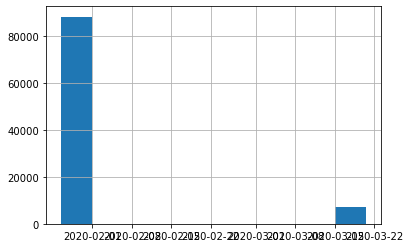

In [7]:
#examine overall distribution of dates
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].hist()

min: 2020-01-26 11:08:27 max:  2020-01-29 22:52:15 mean:  2020-01-28 14:33:45.298475008


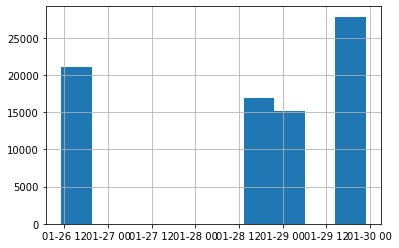

In [37]:
#examine normal dist.. of dates
normal['timestamp'] = pd.to_datetime(normal['timestamp'])
normal['timestamp'].hist()
print('min:', min(normal['timestamp']), 'max: ', max(normal['timestamp']), 'mean: ', np.mean(normal['timestamp']))

min: 2020-01-28 14:42:03 max:  2020-03-20 11:00:03 mean:  2020-02-23 04:42:29.858446848


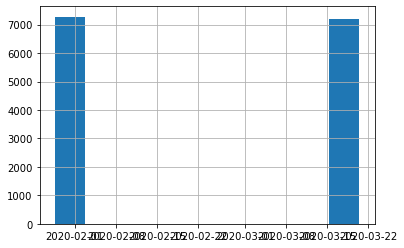

In [51]:
#examine anormal dist. of dates
abnormal['timestamp'] = pd.to_datetime(abnormal['timestamp'])

abnormal['timestamp'].hist()

print('min:', min(abnormal['timestamp']), 'max: ', max(abnormal['timestamp']), 'mean: ', np.mean(abnormal['timestamp']))

In [52]:
# test for duplicates

print(df['timestamp'].duplicated().value_counts())
df[df['timestamp'].duplicated() == True]['timestamp'].head()

print(df.timestamp.duplicated().value_counts())
print(normal.timestamp.duplicated().value_counts())
print(abnormal.timestamp.duplicated().value_counts())

False    77332
True     17978
Name: timestamp, dtype: int64
False    77332
True     17978
Name: timestamp, dtype: int64
False    67267
True     13584
Name: timestamp, dtype: int64
False    14375
True        86
Name: timestamp, dtype: int64


The fact that there is so many duplicate values to the second indicates that this dataset might not be that accurate. It'll be better to drop these duplicates to have clarity for analysis moving forward. I can always fill in empty values with rolling ones if this causes issues. 

In [53]:
#drop duplicates
df.drop(df['timestamp'].duplicated(),inplace=True)

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

<AxesSubplot:xlabel='timestamp', ylabel='Density'>

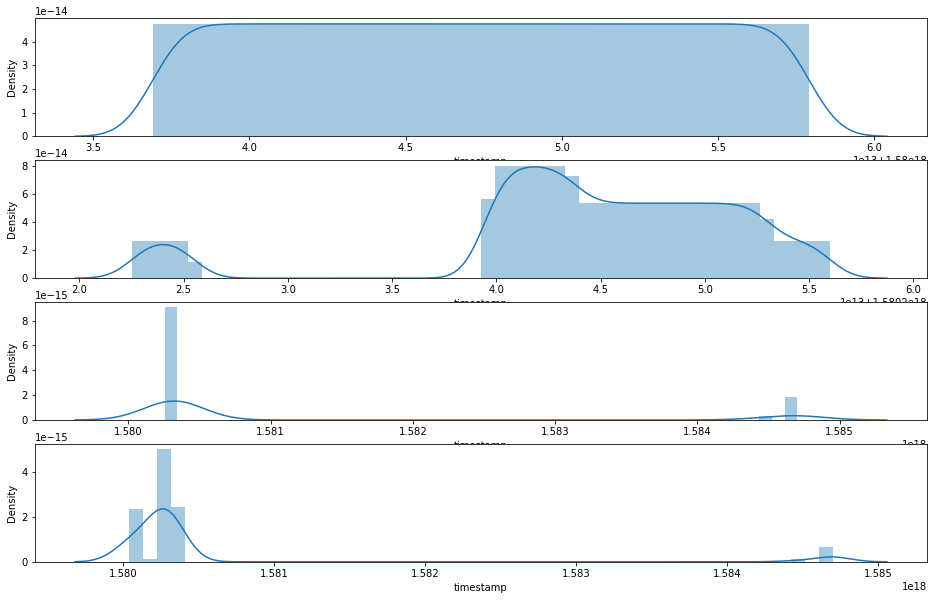

In [54]:
fig, axes = plt.subplots(4,figsize=(16,10))

sns.distplot(a = df[df['timestamp'] <'2020-01-28']['timestamp'], ax= axes[0], hist=True)
sns.distplot(a = df[(df['timestamp'] < '2020-01-29') & (df['timestamp'] >= '2020-01-28')]['timestamp'], ax= axes[1], hist=True)
sns.distplot(a = df[(df['timestamp'] >= '2020-01-29')]['timestamp'], ax= axes[2], hist=True)
sns.distplot(a = df['timestamp'], ax= axes[3], hist=True)

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

<AxesSubplot:xlabel='timestamp', ylabel='Density'>

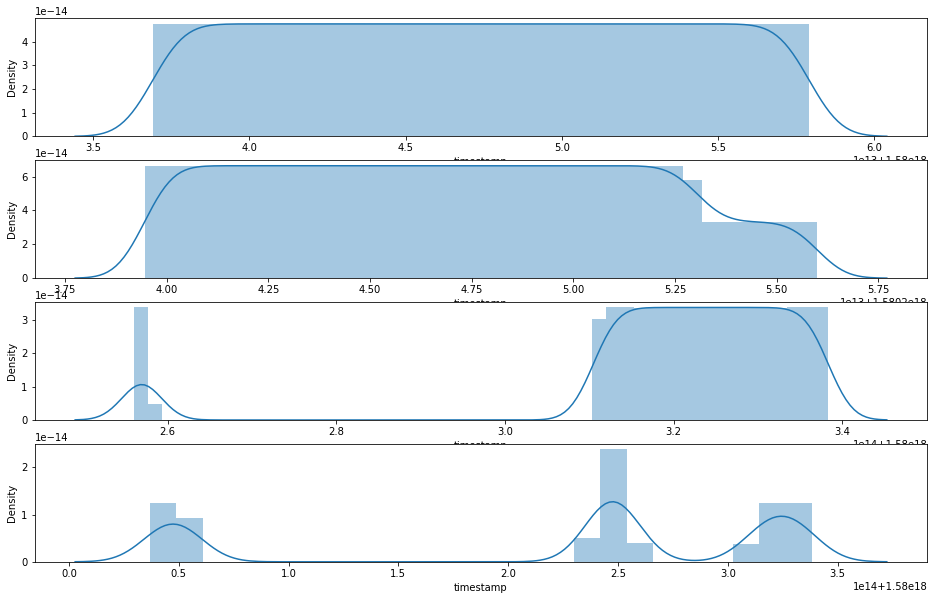

In [43]:
fig, axes = plt.subplots(4,figsize=(16,10))

sns.distplot(a = normal[normal['timestamp'] <'2020-01-28']['timestamp'], ax= axes[0], hist=True)
sns.distplot(a = normal[(normal['timestamp'] < '2020-01-29') & (normal['timestamp'] >= '2020-01-28')]['timestamp'], ax= axes[1], hist=True)
sns.distplot(a = normal[(normal['timestamp'] >= '2020-01-29')]['timestamp'], ax= axes[2], hist=True)
sns.distplot(a = normal['timestamp'], ax= axes[3], hist=True)

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='timestamp', ylabel='Density'>

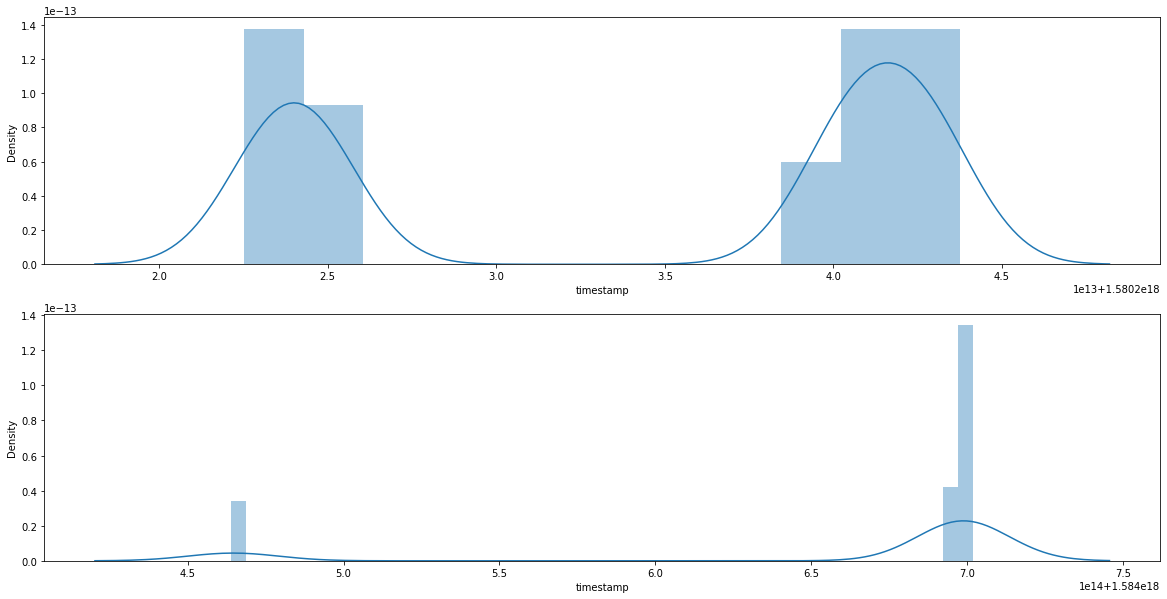

In [32]:
fig, axes = plt.subplots(2,figsize=(20,10))

sns.distplot(a = abnormal[abnormal['timestamp'] <'2020-03-01']['timestamp'], ax= axes[0], hist=True)
sns.distplot(a = abnormal[abnormal['timestamp'] >'2020-03-01']['timestamp'], ax= axes[1], hist=True)

#plt.axes.set_title('Abnormal Time Series Frequency')

Examining the difference between normal and anormal sets in qualitative characteristics will help distinguish between the time series. 

In [10]:
print(abnormal['fs_/_device_name'].unique())
print(normal['fs_/_device_name'].unique())

['/dev/mapper/centos-root' 'mnt_point']
['/dev/sda1']


The attack and normal are modeled on separate devices, shown by the device name.

In [11]:
print(abnormal.system_os_version.unique())
print(normal.system_os_version.unique())


['3.10.0-1062.12.1.el7.x86_64' 'localhost.localdomain'
 '3.10.0-1062.el7.x86_64']
['3.10.0-1062.12.1.el7.x86_64']


In [12]:
print(abnormal['fs_/_size'].unique())
print(normal['fs_/_size'].unique())

['4708106240' '/boot' 4708106240]
[10725883904]


In [13]:
print(abnormal['network_lo_cx'].unique())
print(normal['network_lo_cx'].unique())

['200' '0' '288' 'lo' 0 656]
[  0. 288.  nan]


Below, we print correlations between the independent variables in order to understand the role the time series plays in the dataset and find any other important characteristics.

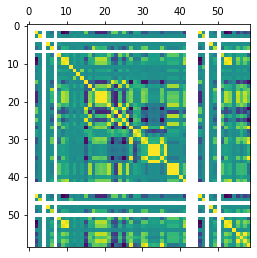

In [16]:
plt.matshow(df.corr())
plt.show();

### Unsupervised ML for EDA

The goal of our unsupervised ML is to determine if the time series are random points and we can just assess this problem as a bianry target, or if we are watching the performance over time of a computer against an attack which will take more time. 

Then we would build a time series model that matches normal computer performance and using testing, we can null hypothesis against test sets that are either normal or abnormal. 